# Домашнее задание №3

Задание присылать на почту **(aleksartmonov@gmail.com)** в формах *.ipynb* и отрендеренный результат в *.html*

В теме письма указать **HSE2019 HW3 <Фамилия Имя>**

soft deadline: 24.02.2019T23:59:00+0300

hard deadline: 03.03.2019T23:59:00+0300


In [197]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/My\ Drive/tmp/image_an -r ./
%cd image_an

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/image_an/image_an/image_an


In [0]:
import numpy as np
import cv2
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('default')

In [0]:
def show_bgr(ax, img, size=3):
    ax.set_axis_off()
    ax.imshow(img)

def show_gray(ax, img, size=3):
    ax.set_axis_off()
    ax.imshow(img, cmap='gray')

def show(imgs, size=5):
    nrows, ncols = len(imgs), max(len(row) for row in imgs)
    _, axs = plt.subplots(nrows, ncols, figsize=(ncols * size, nrows * size), squeeze=False)
    for axs_row, imgs_row in zip(axs, imgs):
        for ax, img in zip(axs_row, imgs_row):
            if len(img.shape) == 3:
                show_bgr(ax, img)
            else:
                show_gray(ax, img)

lena = cv2.imread('lena.jpg')

## Выделение листьев

Суперпиксель

In [0]:
!unzip -q leaves.zip

In [0]:
import os
imgs = []
files = []
for img in os.listdir("leaves"):
    files.append(img)
files.sort()
files = np.asarray(files[1:])
for img in files:
    imgs.append(cv2.cvtColor(cv2.imread("leaves/" + img), cv2.COLOR_BGR2RGB))

In [0]:
imgs_teacher = []
ids_teacher = []
for img in os.listdir("teacher"):
    id = np.where(files == img)[0][0]
    ids_teacher.append(id)
    imgs_teacher.append(cv2.cvtColor(cv2.imread("teacher/" + img), cv2.COLOR_BGR2RGB))

186


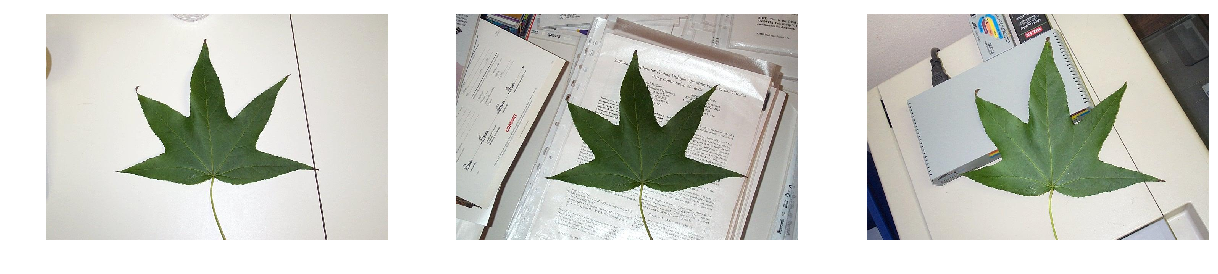

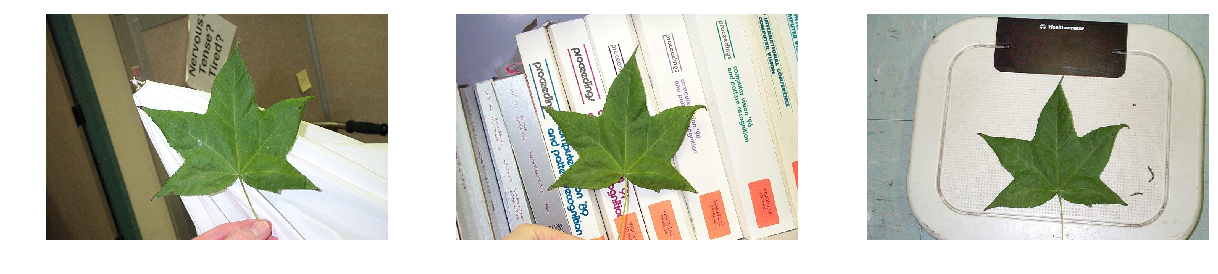

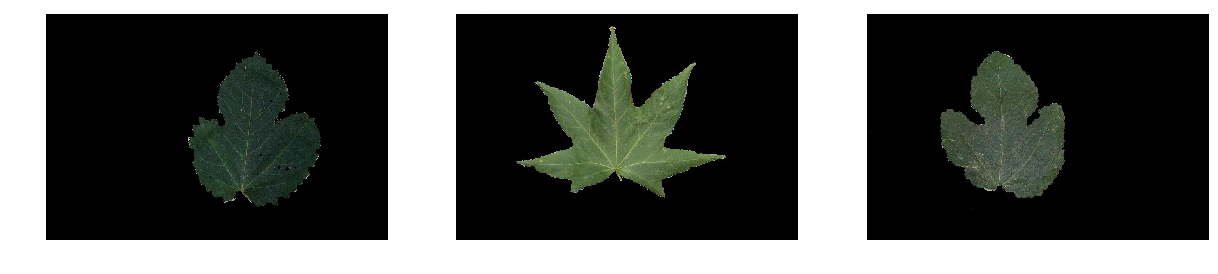

In [159]:
print(len(imgs))
show([imgs[:3]])
show([imgs[50:53]])
show([imgs_teacher[:3]])

SuperPixel

In [0]:
maxdif = 30

def remove_back(img):
    res = img.copy()
    h, w, _ = img.shape
    rr, gg, bb = img[h//2, w//2]
    
    for i in range(h):
        for j in range(w):
            r, g, b = img[i][j]
            if r > 140 and g > 140 and b > 140:
                res[i][j] = [0, 0, 0]
            elif r < 30 and g < 30 and b < 30:
                res[i][j] = [0, 0, 0]
            elif b > g or r > g:
                res[i][j] = [0, 0, 0]
    return res

imgs_new = []
for id in range(len(imgs)):
    imgs_new.append(remove_back(imgs[id]))

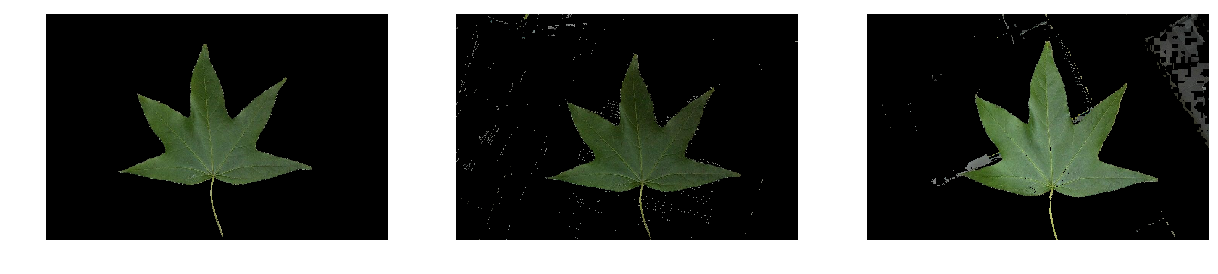

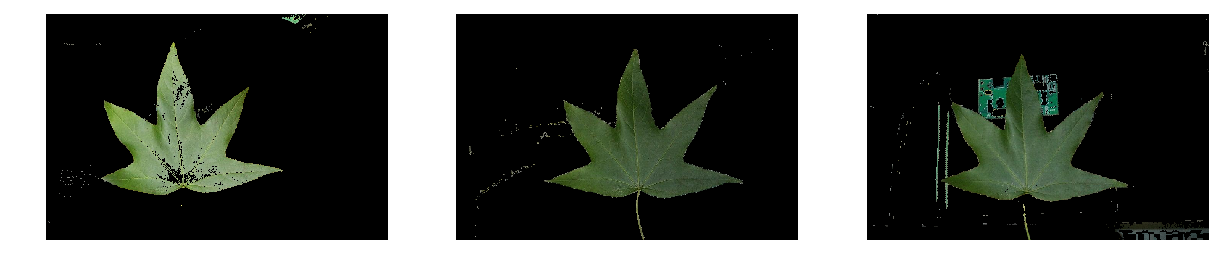

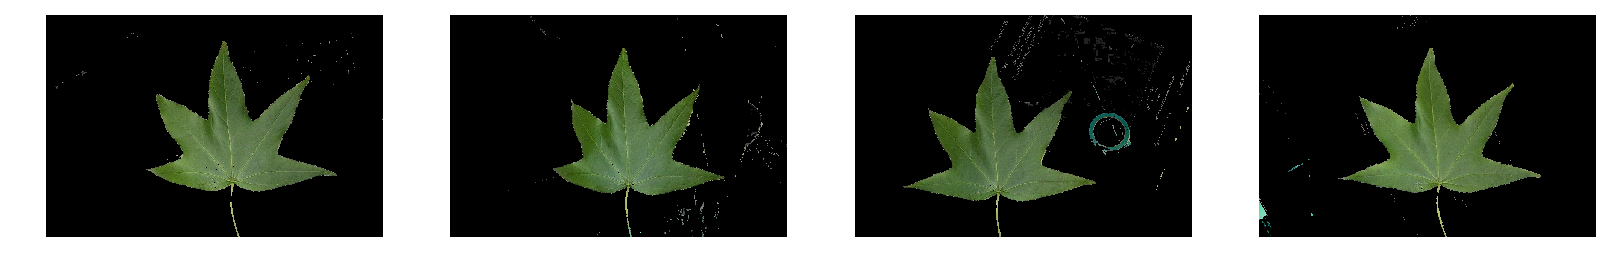

In [138]:
show([imgs_new[:3]])
show([imgs_new[3:6]])
show([imgs_new[6:10]])

In [0]:
imgs_morph = []
for img in imgs_new:
    tmp = cv2.morphologyEx(img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))
    imgs_morph.append(tmp)

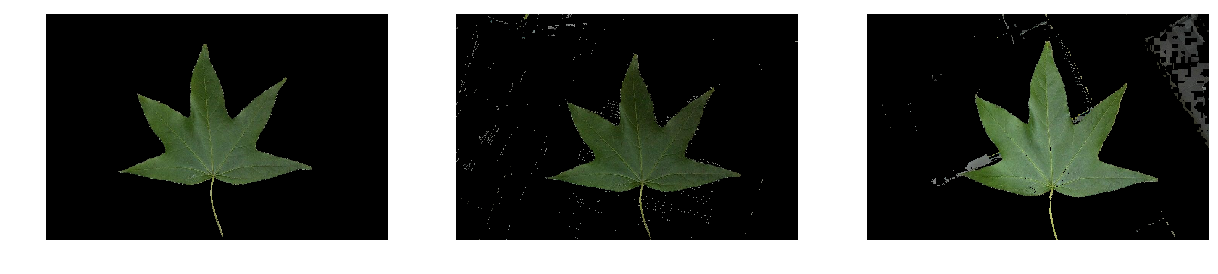

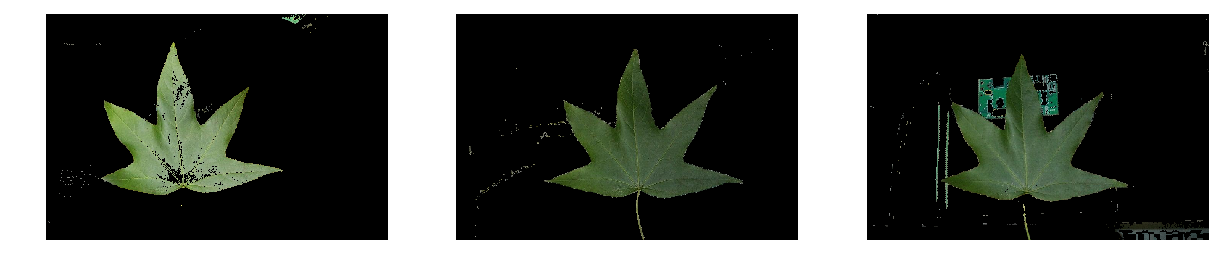

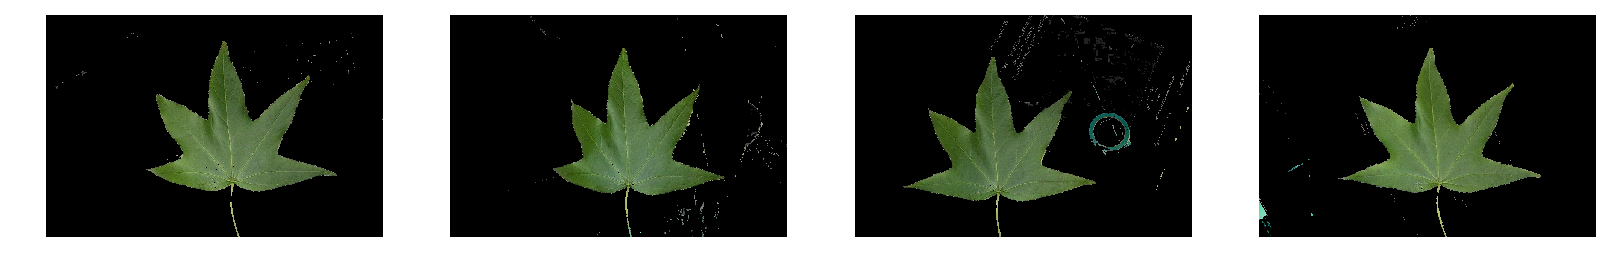

In [206]:
show([imgs_new[:3]])
show([imgs_new[3:6]])
show([imgs_new[6:10]])

In [0]:
ids = [76, 89, 119, 121, 122, 123, 124, 151, 152, 153, 158]
for id in ids:
    img=imgs_morph[id]
    cv2.imwrite("result/" + files[id], cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    gfiles.download("result/" + files[id]) 

In [0]:
segments = []
n_segments = 1500
for img in imgs_morph:
    segments.append(slic(img_as_float(img), n_segments=n_segments, slic_zero=True))

In [141]:
print(imgs[0].shape)
print(segments[0].shape)
print(imgs_new[0].dtype)

(592, 896, 3)
(592, 896)
uint8


In [0]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage import io

def extract_features(img, seg):
    vis = np.zeros((np.max(seg) + 1, 3), dtype="float")
    rs = [[] for _ in range(np.max(seg) + 1)]
    gs = [[] for _ in range(np.max(seg) + 1)]
    bs = [[] for _ in range(np.max(seg) + 1)]
    for i in range(seg.shape[0]):
        for j in range(seg.shape[1]):
            r_, g_, b_ = img[i][j]
            rs[seg[i][j]].append(r_)
            gs[seg[i][j]].append(g_)
            bs[seg[i][j]].append(b_)
    for i in range(len(rs)):
        r, g, b = rs[i], gs[i], bs[i]
        n = len(r) + 0.
        r, g, b = np.asarray(r), np.asarray(g), np.asarray(b)
        vis[i] = [r.sum() / n, g.sum() / n, b.sum() / n]
        
        #rg = np.absolute(r - g)
        #yb = np.absolute(0.5 * (r + g) - b)
        #stdRoot = np.sqrt((rg.std() ** 2) + (yb.std() ** 2))
        #meanRoot = np.sqrt((rg.mean() ** 2) + (yb.mean() ** 2))
        #vis[i] = [stdRoot, meanRoot]
    return vis

In [172]:
origs_teach = []
lbls_teach = []
for idx, id in enumerate(ids_teacher):
    img = imgs_teacher[idx]
    h, w, _ = img.shape
    tmp = []
    for i in range(h):
        for j in range(w):
            if img[i][j][0] != 0 and img[i][j][1] != 0 and img[i][j][2] != 0:
                tmp.append(1)
            else:
                tmp.append(0)
    lbls_teach.extend(np.asarray(tmp))
    tmp = imgs_morph[id].reshape((h*w, 3))
    for col in tmp:
        origs_teach.append(col)
origs_teach = np.asarray(origs_teach)
lbls_teach = np.asarray(lbls_teach).flatten()
print(origs_teach.shape, lbls_teach.shape)

(12199936, 3) (12199936,)


In [173]:
clustering = RandomForestClassifier().fit(origs_teach, lbls_teach)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[1240, 0], [217, 1]]
[[1172, 0], [283, 1]]
[[1010, 0], [441, 1]]
[[1087, 0], [369, 1]]
[[1187, 0], [267, 1]]


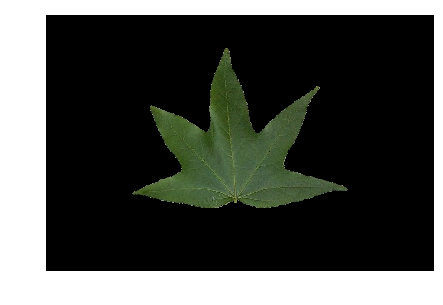

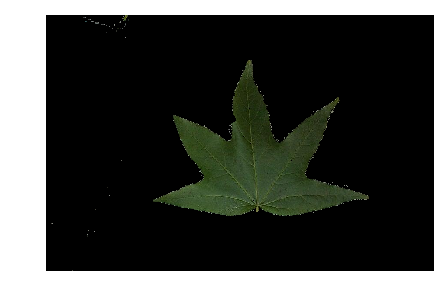

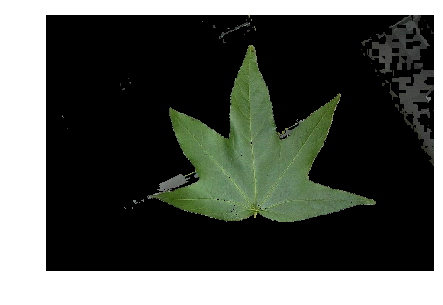

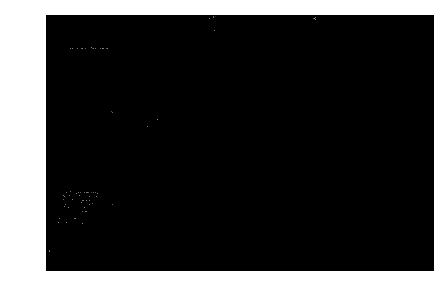

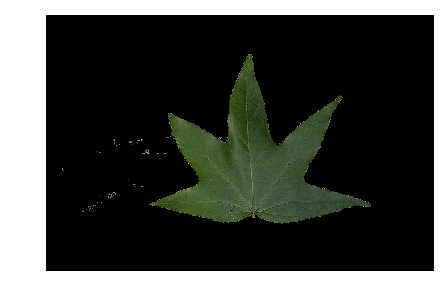

In [182]:
from sklearn.cluster import MeanShift
from sklearn.ensemble import RandomForestClassifier
from google.colab import files as gfiles

res = []
for id, seg in enumerate(segments[:5]):
    vis = extract_features(imgs[id], seg)
    clustering = MeanShift().fit(vis)
    lbls = clustering.labels_
    counts = []
    for lbl in np.unique(lbls):
        m = len(lbls[lbls == lbl])
        counts.append([m, lbl])
    counts.sort(reverse=True)
    print(counts)
    leaf_lbl = counts[1][1]
    output = np.full(imgs[id].shape, 0, dtype=np.uint8)

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if lbls[seg[i][j]] == leaf_lbl:
                r, g, b = imgs_new[id][i][j]
                output[i][j] = [b, g, r]
    output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
    res.append(output)
    show([[output]])
    #cv2.imwrite("result/" + files[id], output)
    #gfiles.download("result/" + files[id]) 

In [0]:

print(vis.shape)
clustering = MeanShift().fit(vis)

(2071, 3)


In [0]:
lbls = clustering.labels_
counts = []
for lbl in np.unique(lbls):
    m = len(lbls[lbls == lbl])
    counts.append([m, lbl])
counts.sort(reverse=True)
print(counts)

[[1758, 0], [303, 1], [10, 2]]


In [0]:
leaf_lbl = counts[1][1]
output = np.zeros((orig.shape[:2]))

for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        if lbls[segments[i][j]] == leaf_lbl:
            output[i][j] = 255 

In [0]:
print(len(imgs))

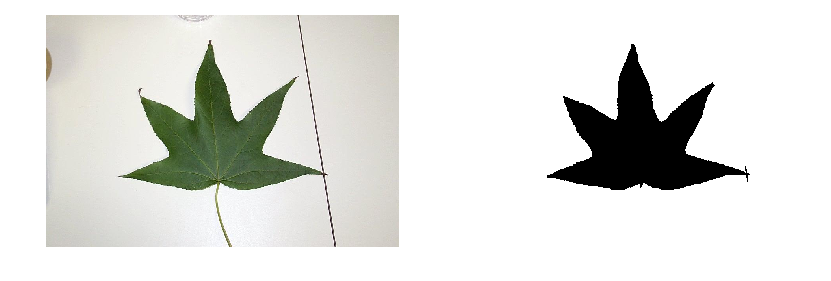

In [0]:
show([[orig, output]])

Грабкат

(592, 896, 3)


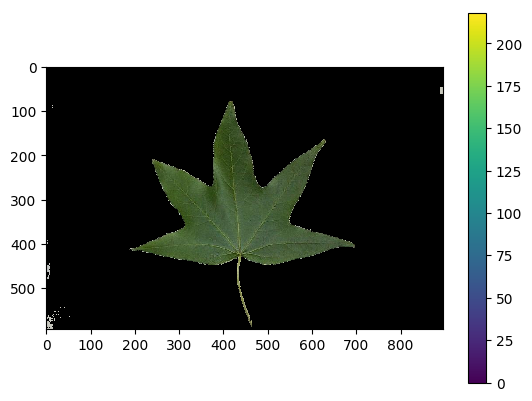

(<matplotlib.image.AxesImage at 0x7f0c749ff5c0>,
 None)

In [0]:
img = imgs_new[0]
print(img.shape)
plt.imshow(img),plt.colorbar(),plt.show()


In [189]:
img = imgs_morph[0]
cols = [0, 0, 0]
n_c = 0.
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if img[i][j].any() != 0:
            cols[0] += img[i][j][0]
            cols[1] += img[i][j][1]
            cols[2] += img[i][j][2]
            n_c += 1
cols[0] /= n_c
cols[1] /= n_c
cols[2] /= n_c
print(cols)

[74.88030074405536, 99.05780737811541, 57.57099745043967]


In [0]:
for id, img in enumerate(imgs_morph):
    h, w, _ = img.shape
    mask = np.full((h, w), 2, np.uint8)
    for i in range(h):
        for j in range(w):
            if abs(img[i][j][0] - cols[0]) <= 15 and abs(img[i][j][1] - cols[1]) <= 15 and abs(img[i][j][2] - cols[2]) <= 15:
                mask[i][j] = 1
    
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    rect = (150, 50, 600, 500)
    cv2.grabCut(img,mask,None,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_MASK)

    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = imgs[id]*mask2[:,:,np.newaxis]
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))
    cv2.imwrite("result/" + files[id], cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    gfiles.download("result/" + files[id]) 